In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle

import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

In [2]:
with open('mldf_1000_full_dec.p', "rb") as input_file:
    mldf = pickle.load(input_file)
for i in ['mldf_1000_full_mar.p', 'mldf_1000_full_sep.p', 'mldf_1000_full_jun.p']:
    with open(i, "rb") as input_file:
        mldf = mldf.append(pickle.load(input_file))

mldf = mldf[mldf < 1000000]
mldf = mldf[mldf > -1000000]
mldf = mldf.dropna()

for o in mldf:
    mldf[o] = mldf[o].astype(float)
mldf = mldf.dropna()

cut = int(len(mldf)*0.80)
train = mldf[:cut]
test = mldf[cut:]

In [3]:
new = test.reset_index()
testidx = []
for i in range(len(new)):
    if i != 0:
        if new.z[i] < new.z[i-1]:
#             print('z[',i-1,']: ', new.z[i-1], 'z[',i,']: ',new.z[i], '')
            testidx.append(i)

In [4]:
len(testidx)

2314

---

In [6]:
with open('mldf_4seasons_prev.p', "rb") as input_file:
    mldf = pickle.load(input_file)
    
mldf = mldf[mldf < 1000000]
mldf = mldf[mldf > -1000000]
mldf = mldf.dropna()

for o in mldf:
    mldf[o] = mldf[o].astype(float)
mldf = mldf.dropna()

cut = int(len(mldf)*0.80)
train = mldf[:cut]
test = mldf[cut:]

new = test.reset_index()
testidx = []
for i in range(len(new)):
    if i != 0:
        if new.z[i] < new.z[i-1]:
#             print('z[',i-1,']: ', new.z[i-1], 'z[',i,']: ',new.z[i], '')
            testidx.append(i)

In [7]:
len(testidx)

246

In [8]:
mldf

,index,temperature,pressure,u,v,latd,lond,lat,lon,calc_latd,calc_lond,z,u_shear,v_shear,prev_calc_lond,prev_calc_latd,lon_diff,lat_diff
1,1.0,275.03,82520.0,1.212436,-0.700000,0.00002,0.00022,43.06,-108.48,-0.000015,0.000007,1620.498023,-0.059637,0.094879,0.000000,0.000000,0.000007,-0.000015
2,2.0,275.11,82470.0,1.158308,-0.590188,-0.00004,0.00028,43.06,-108.48,-0.000029,0.000012,1625.378104,-0.054127,0.109812,0.000007,-0.000015,0.000006,-0.000014
3,3.0,275.20,82420.0,1.137006,-0.630253,-0.00010,0.00029,43.06,-108.48,-0.000043,0.000018,1630.262654,-0.021303,-0.040065,0.000012,-0.000029,0.000005,-0.000014
4,4.0,275.40,82370.0,1.096255,-0.488084,-0.00014,0.00024,43.06,-108.48,-0.000056,0.000022,1635.152743,-0.040751,0.142169,0.000018,-0.000043,0.000005,-0.000013
5,5.0,275.63,82310.0,0.980107,-0.499390,-0.00013,0.00012,43.06,-108.48,-0.000071,0.000028,1641.029355,-0.116147,-0.011306,0.000022,-0.000056,0.000005,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28652796,999995.0,244.00,31170.0,18.115284,-11.764203,-0.07523,0.04137,27.78,-97.51,-0.077793,0.033945,9416.307818,0.000000,0.000000,0.033849,-0.077625,0.000097,-0.000169
28652797,999996.0,243.98,31150.0,18.115284,-11.764203,-0.07540,0.04150,27.78,-97.51,-0.077962,0.034042,9420.891833,0.000000,0.000000,0.033945,-0.077793,0.000097,-0.000169
28652798,999997.0,243.94,31130.0,18.115284,-11.764203,-0.07560,0.04166,27.78,-97.51,-0.078131,0.034140,9425.478228,0.000000,0.000000,0.034042,-0.077962,0.000097,-0.000169
28652799,999998.0,243.90,31120.0,18.115284,-11.764203,-0.07576,0.04178,27.78,-97.51,-0.078216,0.034188,9427.772154,0.000000,0.000000,0.034140,-0.078131,0.000049,-0.000084


In [9]:
with open('mldf_1000_full_dec.p', "rb") as input_file:
    mldf = pickle.load(input_file)
for i in ['mldf_1000_full_mar.p', 'mldf_1000_full_sep.p', 'mldf_1000_full_jun.p']:
    with open(i, "rb") as input_file:
        mldf = mldf.append(pickle.load(input_file))

mldf = mldf[mldf < 1000000]
mldf = mldf[mldf > -1000000]
mldf = mldf.dropna()

for o in mldf:
    mldf[o] = mldf[o].astype(float)
mldf = mldf.dropna()

new = mldf.reset_index()
testidx = [0]
for i in range(1,len(new)):
    if new.z[i] < new.z[i-1]:
        print(i)
        testidx.append(i)
        
test1 = [0] + list(new.calc_lond[:-1])
test2 = [0] + list(new.calc_latd[:-1])

for i in testidx:
    test1[i]=np.nan
    test2[i]=np.nan
new['prev_calc_lond']= test1
new['prev_calc_latd']= test2
new.dropna()

new['lon_diff'] = np.array(new.calc_lond - new.prev_calc_lond)
new['lat_diff'] = np.array(new.calc_latd - new.prev_calc_latd)

new.to_pickle('mldf_4seasons_prev.p')

2642
5589
8531
11281
14281
17040
20111
23295
26486
29610
32524
35405
38363
41393
43993
46925
50218
53449
56692
59991
63089
66313
69827
73054
76513
79679
83061
85658
89118
92310
95667
98734
102353
104847
107740
109529
112712
115587
119018
122072
125483
128718
131649
135012
137434
140287
143271
146846
149884
152569
155632
158462
161466
164192
166974
170027
172938
176013
178967
182081
184920
187997
190929
194034
197268
200581
203836
207135
210527
213764
216874
220054
223386
226625
229570
232799
236184
239817
242857
246589
250402
253547
257008
259955
263302
266461
269548
272736
276010
279467
282155
285126
288371
291981
294643
297364
300242
303020
305530
308361
311334
314223
317224
320052
323133
326098
329042
332059
335231
338410
341540
344844
347882
351396
354635
357397
360604
363671
366718
370118
373244
376391
379590
383083
386434
389827
392890
396503
399609
402546
405520
408645
412024
415355
418255
421616
424596
427785
431069
434557
437541
440577
443132
446020
449184
452433
455040
458055

In [15]:
mldf = new.dropna()
for o in mldf:
    mldf[o] = mldf[o].astype(float)
mldf = mldf.dropna()

cut = int(len(mldf)*0.80)
train = mldf[:cut]
test = mldf[cut:]

new = test.reset_index()
testidx = []
for i in range(len(new)):
    if i != 0:
        if new.z[i] < new.z[i-1]:
#             print('z[',i-1,']: ', new.z[i-1], 'z[',i,']: ',new.z[i], '')
            testidx.append(i)
print('len(testidx)', len(testidx))

ValueError: cannot insert level_0, already exists

In [14]:
mldf = new[new < 1000000]
mldf

,level_0,index,temperature,pressure,u,v,latd,lond,lat,lon,calc_latd,calc_lond,z,u_shear,v_shear,prev_calc_lond,prev_calc_latd,lon_diff,lat_diff
0,NaN,193655.0,208.83,17740.0,-28.453346,-8.158866,0.42575,0.17706,36.05,-115.19,0.511809,0.140475,13000.496376,0.000000,0.000000,0.140425,0.511591,0.000051,0.000218
1,NaN,193656.0,208.81,17720.0,-28.549472,-8.186429,0.42600,0.17715,36.05,-115.19,0.512245,0.140577,13007.391385,-0.096126,-0.027564,0.140475,0.511809,0.000101,0.000436
2,NaN,193657.0,208.78,17710.0,-28.549472,-8.186429,0.42627,0.17724,36.05,-115.19,0.512464,0.140628,13010.841395,0.000000,0.000000,0.140577,0.512245,0.000051,0.000219
3,NaN,193658.0,208.74,17700.0,-28.645599,-8.213993,0.42653,0.17735,36.05,-115.19,0.512683,0.140679,13014.292775,-0.096126,-0.027564,0.140628,0.512464,0.000051,0.000219
4,NaN,193659.0,208.72,17690.0,-28.497882,-8.712677,0.42678,0.17745,36.05,-115.19,0.512902,0.140731,13017.745609,0.147717,-0.498684,0.140679,0.512683,0.000053,0.000219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796466,NaN,999995.0,244.00,31170.0,18.115284,-11.764203,-0.07523,0.04137,27.78,-97.51,-0.077793,0.033945,9416.307818,0.000000,0.000000,0.033849,-0.077625,0.000097,-0.000169
796467,NaN,999996.0,243.98,31150.0,18.115284,-11.764203,-0.07540,0.04150,27.78,-97.51,-0.077962,0.034042,9420.891833,0.000000,0.000000,0.033945,-0.077793,0.000097,-0.000169
796468,NaN,999997.0,243.94,31130.0,18.115284,-11.764203,-0.07560,0.04166,27.78,-97.51,-0.078131,0.034140,9425.478228,0.000000,0.000000,0.034042,-0.077962,0.000097,-0.000169
796469,NaN,999998.0,243.90,31120.0,18.115284,-11.764203,-0.07576,0.04178,27.78,-97.51,-0.078216,0.034188,9427.772154,0.000000,0.000000,0.034140,-0.078131,0.000049,-0.000084


In [ ]:
model_dt_prev = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10)
model_dt_prev.fit(train[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']], train[['latd', 'lond']])
model_dt = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10)
model_dt.fit(train[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']], train[['latd', 'lond']])

---
---
---


len(testidx) 2280
Latitude Displacement data set 1 - plev:  92500  RMSE:  0.0007291617947495537
Longitude Displacement data set 1 - plev:  92500  RMSE:  0.0009354586223943132
Latitude Displacement data set 2 - plev:  92500  RMSE:  0.00037506551249524877
Longitude Displacement data set 2 - plev:  92500  RMSE:  0.0004095835433905341
Latitude Displacement data set 3 - plev:  92500  RMSE:  0.006375132296219378
Longitude Displacement data set 3 - plev:  92500  RMSE:  0.0003976726183445578
Latitude Displacement data set 1 - plev:  92500  RMS:  0.0007291617947495537
Longitude Displacement data set 1 - plev:  92500  RMS:  0.0009354586223943132
Latitude Displacement data set 1 - plev:  85000  RMSE:  0.0026043349295679762
Longitude Displacement data set 1 - plev:  85000  RMSE:  0.00250430033508105
Latitude Displacement data set 2 - plev:  85000  RMSE:  0.0009442239361081079
Longitude Displacement data set 2 - plev:  85000  RMSE:  0.001063657812737307
Latitude Displacement data set 3 - plev:  850

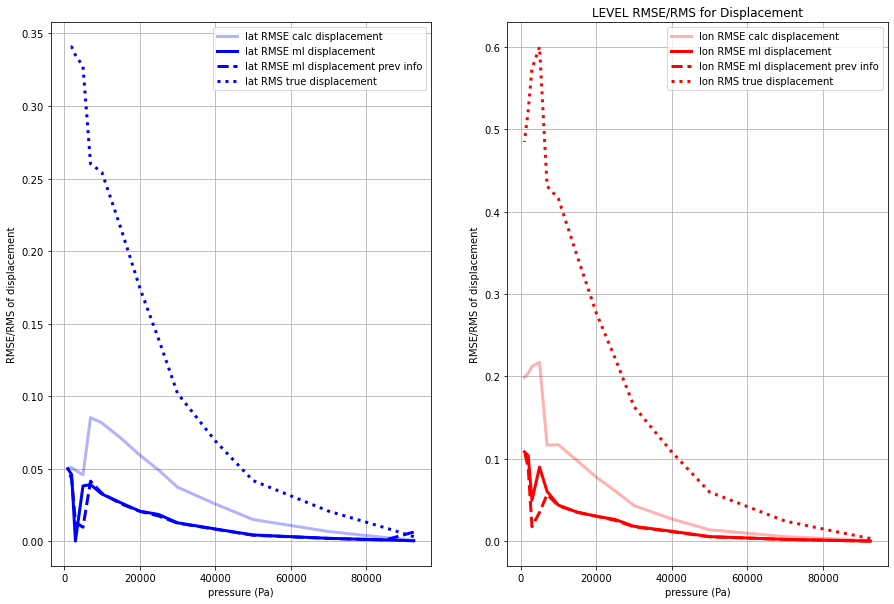

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

# try:
# with open('model_dt_full_4seasons_reduced.p', "rb") as input_file:
#     model_dt = pickle.load(input_file)
# print('loading successful')

# with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
#     model_dt_prev = pickle.load(input_file)
# print('loading successful')

with open('mldf_4seasons_prev.p', "rb") as input_file:
    mldf = pickle.load(input_file)
# mldf = mldf[mldf < 1000000]
# mldf = mldf[mldf > -1000000]
mldf = mldf.dropna()
for o in mldf:
    mldf[o] = mldf[o].astype(float)
mldf = mldf.dropna()

cut = int(len(mldf)*0.80)
train = mldf[:cut]
test = mldf[cut:]

new = test.reset_index()
testidx = []
for i in range(len(new)):
    if i != 0:
        if new.z[i] < new.z[i-1]:
#             print('z[',i-1,']: ', new.z[i-1], 'z[',i,']: ',new.z[i], '')
            testidx.append(i)
print('len(testidx)', len(testidx))

model_dt_prev = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10)
model_dt_prev.fit(train[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']], train[['latd', 'lond']])
model_dt = DecisionTreeRegressor(min_samples_leaf = 5, min_samples_split = 10)
model_dt.fit(train[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']], train[['latd', 'lond']])

# model_dt.score(test[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']], test[['latd', 'lond']])
# with open("model_dt_4s_reduced_prev.p", "wb") as output_file:
#     pickle.dump(model_dt, output_file)

stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_lon_1={}
rmse_sum_lat_1={}
rmse_sum_lon_2={}
rmse_sum_lat_2={}
rmse_sum_lon_3={}
rmse_sum_lat_3={}


rms_sum_lon_0={}
rms_sum_lat_0={}

for i in stdplevs:
    rmse_sum_lon_1[i] = []
    rmse_sum_lat_1[i] = []
    rmse_sum_lon_2[i] = []
    rmse_sum_lat_2[i] = []
    rmse_sum_lon_3[i] = []
    rmse_sum_lat_3[i] = []
    rms_sum_lon_0[i] = []
    rms_sum_lat_0[i] = []
    
for i in range(len(testidx)):
    if i != 0:
        testdata = test[testidx[i-1]:testidx[i]]
        mlout = model_dt.predict(testdata[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']])
        mlout_lat, mlout_lon = mlout.transpose()
        mlout_prev = model_dt_prev.predict(testdata[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])
        mlout_lat_prev, mlout_lon_prev = mlout_prev.transpose()

        for i in range(len(stdplevs)):
            if i > 0:
                b = np.array(testdata.latd)
                c = np.array(testdata.lond)
                b[testdata.pressure < stdplevs[i]] = np.nan
                b[testdata.pressure >= stdplevs[i-1]] = np.nan
                c[testdata.pressure < stdplevs[i]] = np.nan
                c[testdata.pressure >= stdplevs[i-1]] = np.nan
                rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                a = np.array(testdata.calc_lond)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                a = np.array(testdata.calc_latd)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                a = np.array(mlout_lon)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
        #                         
                a = np.array(mlout_lat)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                a = np.array(mlout_lon_prev)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lon_3[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
        #                         
                a = np.array(mlout_lat_prev)
                a[testdata.pressure < stdplevs[i]] = np.nan
                a[testdata.pressure >= stdplevs[i-1]] = np.nan
                rmse_sum_lat_3[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

rmse_lat_1 = []
rmse_lon_1 = []
rmse_lat_2 = []
rmse_lon_2 = []
rmse_lat_3 = []
rmse_lon_3 = []

rms_lat_0 = []
rms_lon_0 = []
for i in range(len(stdplevs)):
    if i > 0:
        rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
        rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
        rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
        print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
        rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
        print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
        rmse_lat_3.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_3[stdplevs[i]])**2))))
        print('Latitude Displacement data set 3 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_3[-1])
        rmse_lon_3.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_3[stdplevs[i]])**2))))
        print('Longitude Displacement data set 3 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_3[-1])

        rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
        rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
print('')
print('ascents: ', len(testidx))
fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE calc displacement')
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE ml displacement')
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_3),color = 'blue', ls='--', label='lat RMSE ml displacement prev info')
ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS true displacement')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
ax1[0].set_xlabel('pressure (Pa)')
ax1[0].set_ylabel('RMSE/RMS of displacement')
ax1[0].legend()
ax1[0].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE calc displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE ml displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_3),color = 'red', ls='--', label='lon RMSE ml displacement prev info')
ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS true displacement')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
ax1[1].set_xlabel('pressure (Pa)')
ax1[1].set_ylabel('RMSE/RMS of displacement')
ax1[1].legend()
ax1[1].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
maplt.show()
maplt.close()

In [17]:
with open('model_dt_4s_reduced.p', "wb") as output_file:
    pickle.dump(model_dt, output_file)
with open('model_dt_4s_reduced_prev.p', "wb") as output_file:
    pickle.dump(model_dt_prev, output_file)

# smoothened data

Latitude Displacement data set 1 - plev:  92500  RMSE:  0.0007291617947495537
Longitude Displacement data set 1 - plev:  92500  RMSE:  0.0009354586223943132
Latitude Displacement data set 2 - plev:  92500  RMSE:  0.002490262576123578
Longitude Displacement data set 2 - plev:  92500  RMSE:  0.0034215024106356157
Latitude Displacement data set 3 - plev:  92500  RMSE:  0.002313926697752643
Longitude Displacement data set 3 - plev:  92500  RMSE:  0.003202580673858165
Latitude Displacement data set 1 - plev:  92500  RMS:  0.0007291617947495537
Longitude Displacement data set 1 - plev:  92500  RMS:  0.0009354586223943132
Latitude Displacement data set 1 - plev:  85000  RMSE:  0.0026043349295679762
Longitude Displacement data set 1 - plev:  85000  RMSE:  0.00250430033508105
Latitude Displacement data set 2 - plev:  85000  RMSE:  0.0022760074494526158
Longitude Displacement data set 2 - plev:  85000  RMSE:  0.0027012431820709645
Latitude Displacement data set 3 - plev:  85000  RMSE:  0.0022370

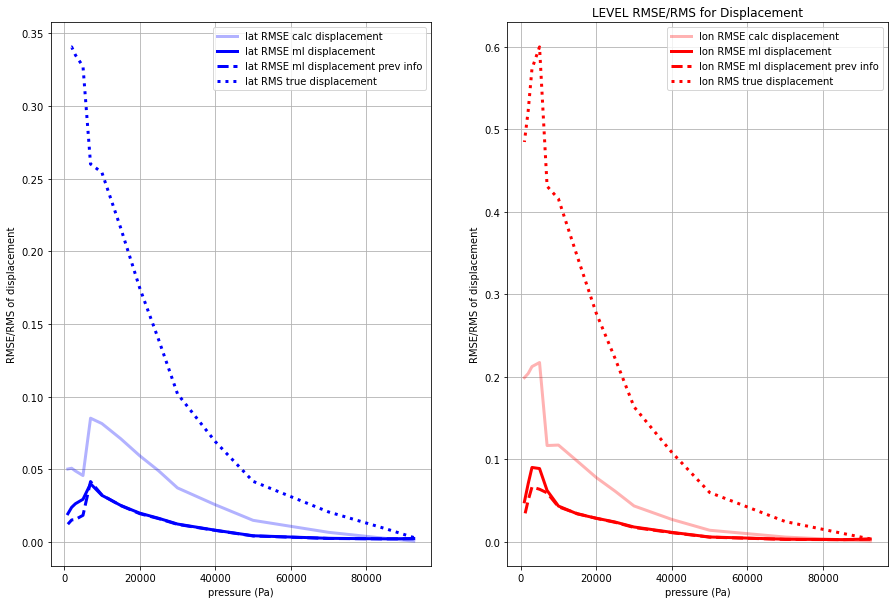

In [19]:
from scipy.signal import savgol_filter

stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_lon_1={}
rmse_sum_lat_1={}
rmse_sum_lon_2={}
rmse_sum_lat_2={}
rmse_sum_lon_3={}
rmse_sum_lat_3={}


rms_sum_lon_0={}
rms_sum_lat_0={}

for i in stdplevs:
    rmse_sum_lon_1[i] = []
    rmse_sum_lat_1[i] = []
    rmse_sum_lon_2[i] = []
    rmse_sum_lat_2[i] = []
    rmse_sum_lon_3[i] = []
    rmse_sum_lat_3[i] = []
    rms_sum_lon_0[i] = []
    rms_sum_lat_0[i] = []
    
for i in range(len(testidx)):
    if i != 0:
        try:
            testdata = test[testidx[i-1]:testidx[i]]
            mlout = model_dt.predict(testdata[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond']])
            mlout_lat, mlout_lon = mlout.transpose()
            mlout_prev = model_dt_prev.predict(testdata[['temperature', 'pressure', 'u', 'v', 'z','lat', 'lon' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])
            mlout_lat_prev, mlout_lon_prev = mlout_prev.transpose()

            filterlen = int(len(testdata)//2)
            if not (filterlen & 0x1):
                filterlen += 1

            for i in range(len(stdplevs)):
                if i > 0:
                    b = np.array(testdata.latd)
                    c = np.array(testdata.lond)
                    b[testdata.pressure < stdplevs[i]] = np.nan
                    b[testdata.pressure >= stdplevs[i-1]] = np.nan
                    c[testdata.pressure < stdplevs[i]] = np.nan
                    c[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                    rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                    a = np.array(testdata.calc_lond)
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                    a = np.array(testdata.calc_latd)
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                    a = np.array(savgol_filter(mlout_lon, filterlen, 3))
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
            #                         
                    a = np.array(savgol_filter(mlout_lat, filterlen, 3))
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

                    a = np.array(savgol_filter(mlout_lon_prev, filterlen, 3))
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lon_3[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.lond[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))
            #                         
                    a = np.array(savgol_filter(mlout_lat_prev, filterlen, 3))
                    a[testdata.pressure < stdplevs[i]] = np.nan
                    a[testdata.pressure >= stdplevs[i-1]] = np.nan
                    rmse_sum_lat_3[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(testdata.latd[testdata.pressure > stdplevs[i]][testdata.pressure <= stdplevs[i-1]]))

        except:
            continue

rmse_lat_1 = []
rmse_lon_1 = []
rmse_lat_2 = []
rmse_lon_2 = []
rmse_lat_3 = []
rmse_lon_3 = []

rms_lat_0 = []
rms_lon_0 = []
for i in range(len(stdplevs)):
    if i > 0:
        rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
        rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
        rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
        print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
        rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
        print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
        rmse_lat_3.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_3[stdplevs[i]])**2))))
        print('Latitude Displacement data set 3 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_3[-1])
        rmse_lon_3.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_3[stdplevs[i]])**2))))
        print('Longitude Displacement data set 3 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_3[-1])

        rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
        print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
        rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
        print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
print('')
print('ascents: ', len(testidx))
fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE calc displacement')
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE ml displacement')
ax1[0].plot(stdplevs[1:],np.array(rmse_lat_3),color = 'blue', ls='--', label='lat RMSE ml displacement prev info')
ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS true displacement')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
ax1[0].set_xlabel('pressure (Pa)')
ax1[0].set_ylabel('RMSE/RMS of displacement')
ax1[0].legend()
ax1[0].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE calc displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE ml displacement')
ax1[1].plot(stdplevs[1:],np.array(rmse_lon_3),color = 'red', ls='--', label='lon RMSE ml displacement prev info')
ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS true displacement')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
ax1[1].set_xlabel('pressure (Pa)')
ax1[1].set_ylabel('RMSE/RMS of displacement')
ax1[1].legend()
ax1[1].grid()
maplt.title('LEVEL RMSE/RMS for Displacement')
maplt.show()
maplt.close()

---
---